# <center>Compulsory Assignment 2</center>  
### <center>Jules de Schutelaere</center>  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.morphology import binary_dilation
import cv2

## 📥 Import M&M's image 

In [3]:
target = io.imread("IMG_2754_nonstop_alltogether.jpg")

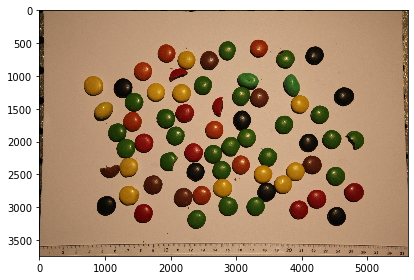

In [4]:
io.imshow(target)

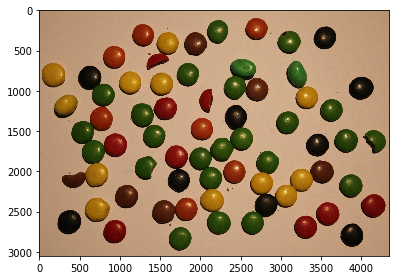

In [7]:
cropped_trgt = target[350:3400,650:5000]
io.imshow(cropped_trgt)

## 🖌 Change image to grayscale and increase contrast

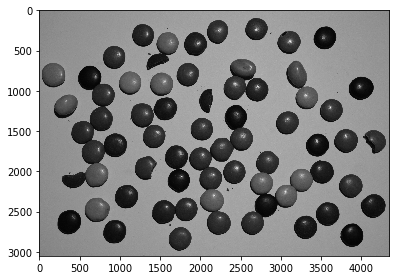

In [8]:
cropped_gray = cv2.cvtColor(cropped_trgt, cv2.COLOR_BGR2GRAY)
io.imshow(cropped_gray)

In [9]:
def change_contrast(im, val):
    image = im.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i,j] = image[i,j]* val
    return image

In [10]:
cropped_gray = change_contrast(cropped_gray,1.4)

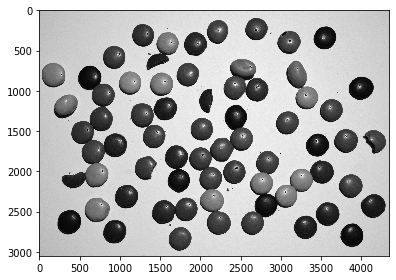

In [11]:
io.imshow(cropped_gray)

## ⚙️ Tuned opening of the picture to improve the Threshold

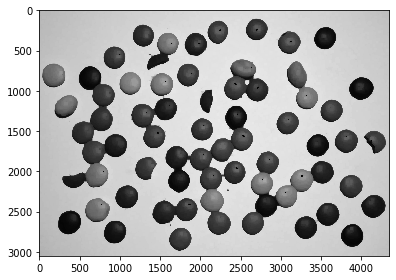

In [12]:
kernel = np.ones((8, 8), np.uint8)
eroded_gray = cv2.erode(cropped_gray, kernel, iterations=3)
opened_gray = cv2.dilate(eroded_gray,kernel,iterations =4)
io.imshow(opened_gray)

## ⚫️ ⚪️ Threshold

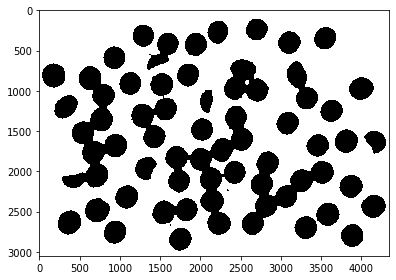

In [13]:
target_trsh = threshold_otsu(opened_gray)
binary = opened_gray < 169
inv_binary =  opened_gray > 169
io.imshow(inv_binary)


## 🔍 Lets separate objects using watershed

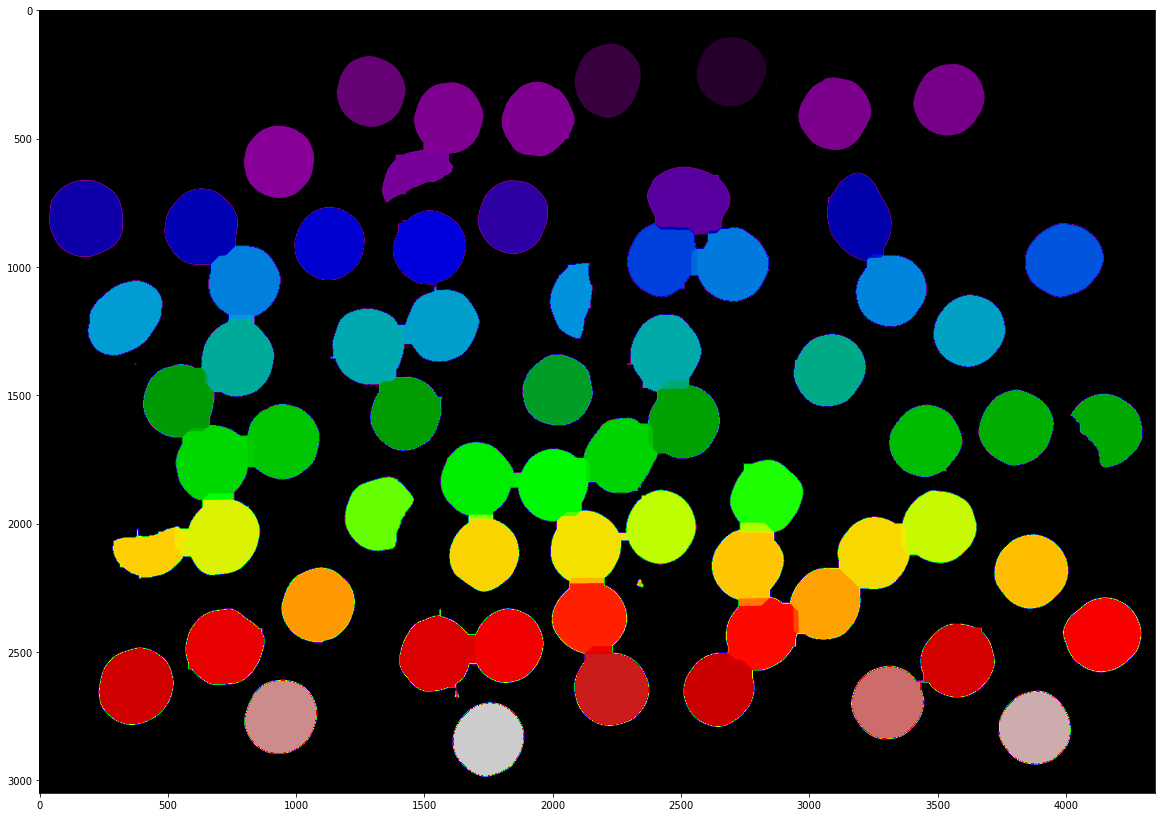

In [18]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(binary)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary, min_distance=100)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=binary)

plt.figure(figsize=[20,20])
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

## ⛔️ 📛 Now we differentiate broken from regular candies

The technique used here is to sort candies using their circularity. The candies are in the outputed labels list of watershed. We discard the small areas (noise). Then  we calculate the circularity of each candy. Finally we set the best circularity level we can to sort the broken candies from the regular ones.

In [15]:
from skimage.measure import find_contours, regionprops

In [16]:
def circularity(area,perimeter):
    return 4*np.pi*(area/(perimeter**2))

In [17]:
from skimage import measure
properties = measure.regionprops(labels)
centroids = []
for prop in properties:   
    if prop.area > 50000 and circularity(prop.area, prop.perimeter) > 0.81:
        centroids+= [np.array(prop.centroid)]
        print(prop.perimeter, prop.area, prop.centroid, circularity(prop.area, prop.perimeter))

891.619407771256 56864 (240.13836522228476, 2697.592800365785) 0.898852113342009
900.4478348960021 57419 (273.35847019279333, 2216.611696476776) 0.8899146828383768
897.9625535217635 57330 (317.0178440607012, 1293.2859236002093) 0.8934604921956587
917.5189027078675 59610 (348.73433987585975, 3546.812682435833) 0.8898134072049242
925.3178925810909 60522 (403.2446548362579, 3101.7538581011863) 0.8882622695515124
906.6488450227787 56353 (416.7248061327702, 1597.8879562756197) 0.8614869038464283
939.0752518939717 61728 (425.47693105235874, 1942.4513348885432) 0.8796122705562301
916.5483399593904 59994 (590.4814814814815, 935.1526152615262) 0.8974431198978342
919.8620484583752 60356 (805.201769500961, 1847.653539001922) 0.8963650435146003
980.0630585851518 68585 (811.1983961507618, 183.09544361011882) 0.8972861569040279
980.0041840821061 61924 (806.762886764421, 3196.7896292229184) 0.810238743547223
957.6610383315985 65395 (844.8412111017661, 631.9826133496445) 0.8960469593176581
914.7909806

## 📊 Graphic representation of the sorting
*Regular candies are surrounded*

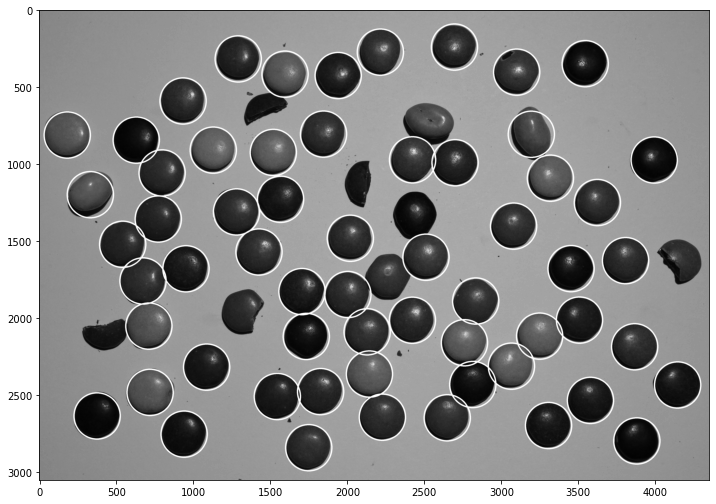

In [136]:
from skimage.draw import circle_perimeter
from skimage import morphology

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))

image = cv2.cvtColor(cropped_trgt, cv2.COLOR_BGR2GRAY)

for centroid in centroids:
    circy, circx = circle_perimeter(int(centroid[0]), int(centroid[1]), 150,
                                    shape=image.shape)
    color = (255, 255, 255)
    cv2.circle(image, np.flip(centroid.astype(int)), 150, color, thickness = 7)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

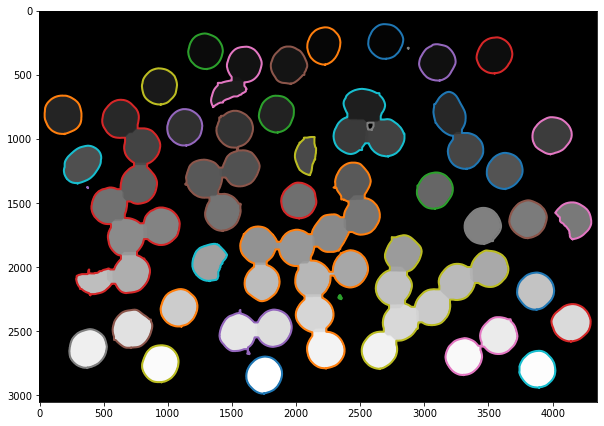

In [69]:

objects = find_contours(image = labels_bis, level=1, fully_connected= "high")


fig, ax = plt.subplots(figsize = [10,10])
ax.imshow(labels, cmap=plt.cm.gray)
for contour in objects:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [115]:
len(np.unique(labels))

111

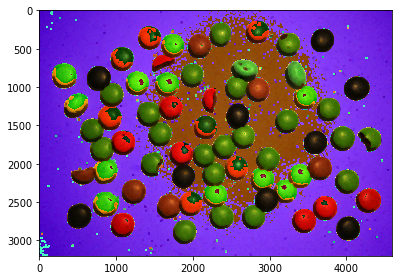

In [58]:
io.imshow(change_contrast(eroded,2))

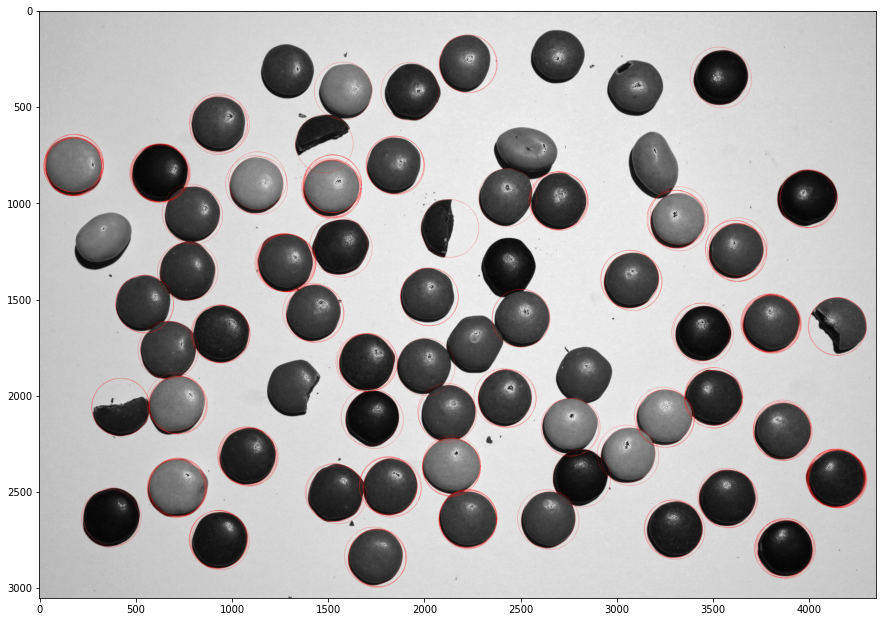

In [35]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(cropped_gray)
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(150, 155,5)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 15))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (255, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()